In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
matplotlib.rc("figure", dpi=120)  # make plots higher resolution
from scipy.stats import poisson
from scipy import constants
# may want to run this block **twice** to get the higher resolution

# Initialize parameters by condition

In [104]:
# stochastic rate constants
c_import  = 5              #2 atom/transporter/s
c_export  = 200             #200 atom/transporter/s
c_assoc1  = 1000           #1000 associations/protein/s  
c_produce = 200           #200 proteins/s or proteins/allmRNA/s, constantly producing protein
c_assoc2  = 800           #800 associations/protein/s
c_dissoc1  = 20            #20 dissociations/protein/s


c = [
    c_import, c_export, c_assoc1, c_produce, c_assoc2, c_dissoc
]

# intial conditions
Zn_out_0 = 10**-7 * constants.N_A * 10**-16 #atoms (molar*Avogadro*volume = molar*6.02214*10**23*volume)
Zn_in_0 = 0
protein_free_0 = 0 # make this constant 
protein_bound_0 = 2000
Zur_free_0 = 1
Zur_Zn_0 = 0


step_total = 15000 # steps
num_reactions = 6

# table describes molecule count changes based on which reaction occurred
# column_features: [Zn_out, Zn_in, protein_free, protein_bound, Zur_free, Zur_Zn]
count_update = np.array([
    [0, 1, 0, 0, 0, 0],  #1 Import Zinc into cytoplasm
    [0, -1, 0, 0, 0, 0],  #2 Export Zinc to periplasmic 
    [0, -1, -1, 1, 0, 0], #3 Zinc-protein binding (in the cell)
    [0, 0, 1, 0, 0, 0],   #4 Metalloprotein w/o cofactor production
    [0, -1, 0, 0, -1, 1], #5 Zinc-Zur association -> one zinc only
    [0, 1, 0, 0, 1, -1],   #6 Zinc-Zur dissociation
])


In [56]:
from re import M
def stochasticSim(seed=42):
    ZnuBC  = 50
    ZntA   = 60
    
    # initialize vectors
    tt = np.zeros(step_total + 1)
    xx = np.zeros((6, step_total + 1)) # row order [Zn_out, Zn_in, protein_free, protein_bound, Zur_free, Zur_Zn]
    qq = np.zeros(step_total) # track reaction that got chosen
    a = np.zeros(num_reactions)

    # insert initial values
    xx[:, 0] = [Zn_out_0, Zn_in_0, protein_free_0, protein_bound_0, Zur_free_0, Zur_Zn_0]

    prng = np.random.RandomState(seed)

    for step in range(step_total): 
        # get most updated molecule count
        [Zn_out, Zn_in, protein_free, protein_bound, Zur_free, Zur_Zn] = xx[:,step]
        
        # update propensities 
        a[0] = c_import * ZnuBC * Zn_out          #1 Import Zinc into cytoplasm #assume one zinc transport at a given step
        a[1] = c_export * Zn_in * ZntA            #2 Export Zinc to periplasmic #assume one zinc transport at a given step
        a[2] = c_assoc1 * protein_free * Zn_in    #3 Zinc-protein binding to make metalloprotein (in the cell) #assume one zinc per protein
        a[3] = c_produce                          #4 Metalloprotein w/o cofactor production
        a[4] = c_assoc2 * Zn_in * Zur_free             #5 Zinc-Zur association -> one zinc only
        a[5] = c_dissoc1 * Zur_Zn                 #6 Zinc-Zur dissociation

        #5 weaker protein binding reaction - Zinc-Zur binding (eventually sequential binding of 4 zinc)
        #6 dissociation
        # new subplot: Zur_free versus time. (Zur_free = 1), just binding, no regulation yet...
        # if you change uptake, you would change Zn conc in the cell, and will change Zur_free conc, (and will change transcription rate) 
        
                
        a_total = np.sum(a)
        # print(a)
        # print(Zn_in)
        # calculate tau
        r1 = prng.rand()
        tau = 1 / a_total * np.log(1 / r1)
        tt[step + 1] = tt[step] + tau

        # determine which reaction occurs
        r2 = prng.rand()
        comparison = a_total * r2
        sum_as = 0
        q = 0
        for reaction in range(num_reactions):
            sum_as += a[reaction]
            if sum_as > comparison:
                q = reaction
                qq[step] = q

                # if q == 4:
                #     ZnuBC -= 10
                # elif q == 5:
                #     ZnuBC += 10
                break

        # update molecule counts based on which reaction occurs
        xx[:, step + 1] = xx[:, step] + count_update[q, :]
    return tt, xx, qq

In [88]:
def plot_sim_results(tt, xx):
    Zn_out = xx[0, :]
    Zn_in = xx[1, :]
    protein_free = xx[2, :]
    protein_bound = xx[3, :]
    Zur_free = xx[4, :]
    Zur_bound = xx[5, :]

    Zur_free_average = sum(Zur_free[:-1]*np.diff(tt))/tt[-1]
    Zn_average = sum(Zn_in[:-1]*np.diff(tt))/tt[-1]
    protein_free_average = sum(protein_free[:-1]*np.diff(tt))/tt[-1]

    # plot results over time
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    # axs[0, 0].step(tt, Zn_out, 'tab:red', where = 'post')
    # axs[0, 0].set_title('Zinc in the Periplasm')
    # axs[0, 0].set(ylabel='Zinc number')

    axs[0, 0].step(tt, Zur_free, 'tab:red', where = 'post')
    axs[0, 0].axhline(Zur_free_average, color = 'orange', linestyle = 'dashed')
    axs[0, 0].text(axs[0, 0].get_xlim()[1] + 0.01, Zur_free_average, f'y={round(Zur_free_average,3)}')
    axs[0, 0].set_title('Free Zur')
    axs[0, 0].set(ylabel='Count')
    
    axs[0, 1].step(tt, Zn_in, 'tab:red', where = 'post')
    axs[0, 1].scatter(tt, Zn_in, color = 'lightpink', marker = 'x')
    axs[0, 1].axhline(Zn_average, color = 'orange', linestyle = 'dashed')
    axs[0, 1].text(axs[0, 1].get_xlim()[1] + 0.01, Zn_average, f'y={round(Zn_average,3)}')
    axs[0, 1].set_title('Free Zinc in the Cytoplasm')
    axs[0, 1].set_ylabel('Zinc number')

    axs[1, 0].step(tt, protein_free, where = 'post')
    axs[1, 0].set_title('Metalloprotein Needing an Zinc Ion')
    axs[1, 0].axhline(protein_free_average, color = 'orange', linestyle = 'dashed')
    axs[1, 0].text(axs[1, 0].get_xlim()[1] + 0.01, protein_free_average, f'y={round(protein_free_average,3)}')
    axs[1, 0].set_ylabel('Protein number')

    axs[1, 1].step(tt, protein_bound, where = 'post')
    axs[1, 1].set_title('Metalloprotein Saturated with Zinc')
    axs[1, 1].set_ylabel('Protein number')

    for ax in axs.flat:
        ax.set_xlabel('Time (s)')

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    return fig

Text(0.5, 0.98, 'Zn import rate = 5 atom/transporter/s, Protein production rate = 200 proteins/s')

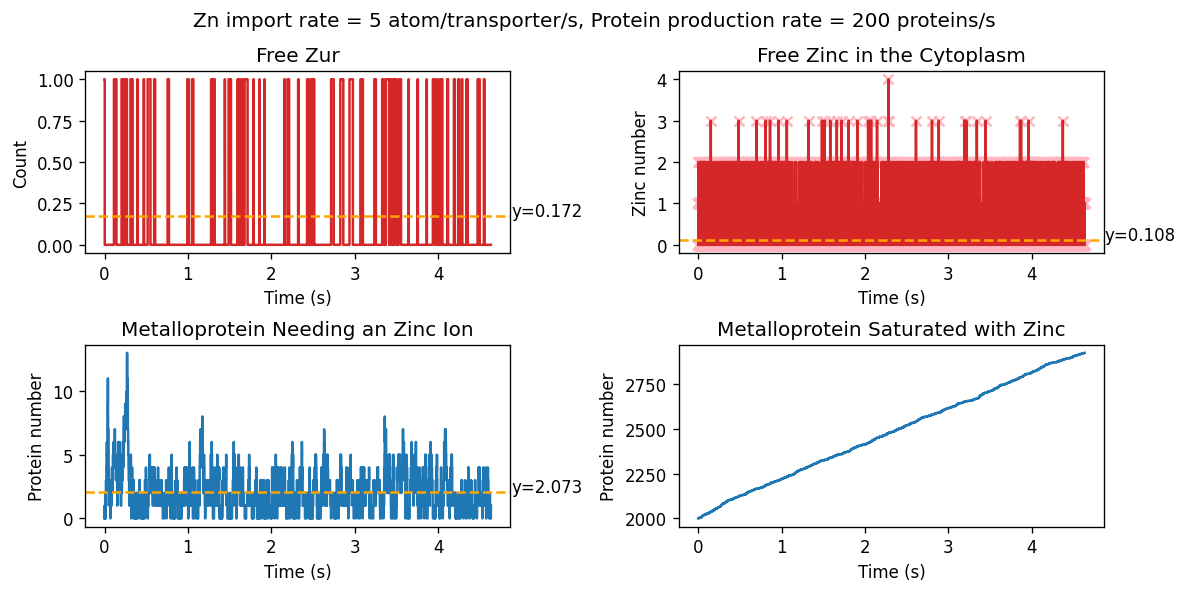

In [105]:
tt, xx, qq = stochasticSim(seed = 50)
fig = plot_sim_results(tt, xx)
fig.suptitle(f'Zn import rate = {c_import} atom/transporter/s, Protein production rate = {c_produce} proteins/s')

[Text(0.25, 0, 'Import'),
 Text(1.25, 0, 'Export'),
 Text(2.25, 0, 'Zinc-Protein Assoc.'),
 Text(3.25, 0, 'Protein Production'),
 Text(4.25, 0, 'Zn-Zur Assoc.'),
 Text(5.25, 0, 'Zn-Zur Dissoc.')]

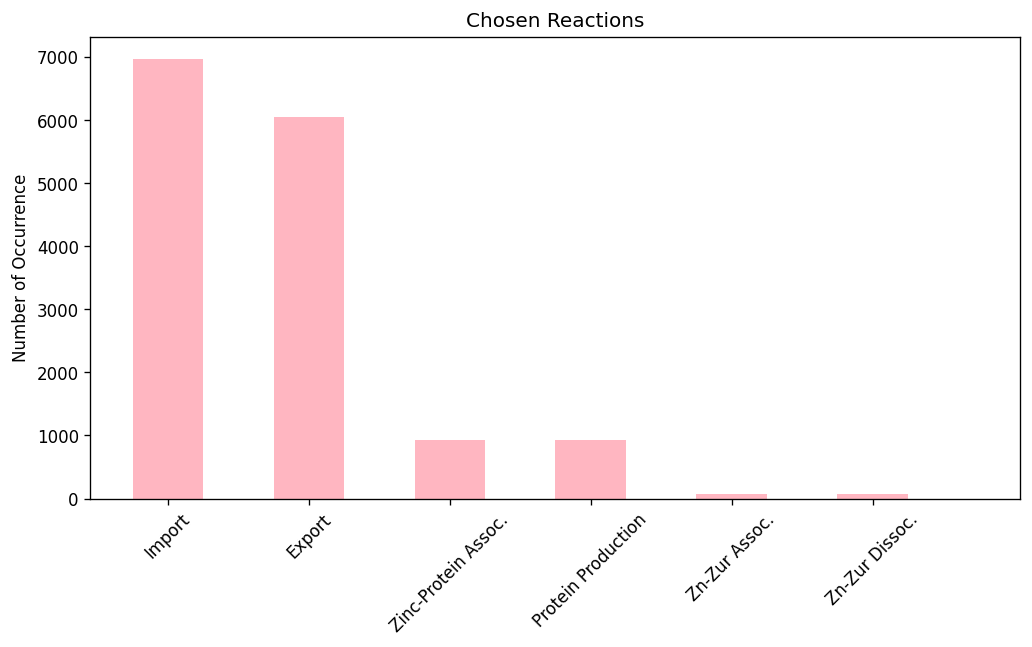

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(qq, bins = range(num_reactions+1), width = 0.5, align = 'mid', color = 'lightpink')
ax.set_title('Chosen Reactions')
ax.set(ylabel='Number of Occurrence')
ax.set_xticks([i + 0.25 for i in range(num_reactions)])
ax.set_xticklabels(['Import', 'Export', 'Zinc-Protein Assoc.', 'Protein Production', 'Zn-Zur Assoc.','Zn-Zur Dissoc.'], rotation = 45)

In [54]:
Zn_out = xx[0, :]
np.min(Zn_out)

602214075999561.0

In [89]:
from collections import Counter
Counter(qq)

Counter({0.0: 4838, 1.0: 4313, 2.0: 522, 3.0: 327})

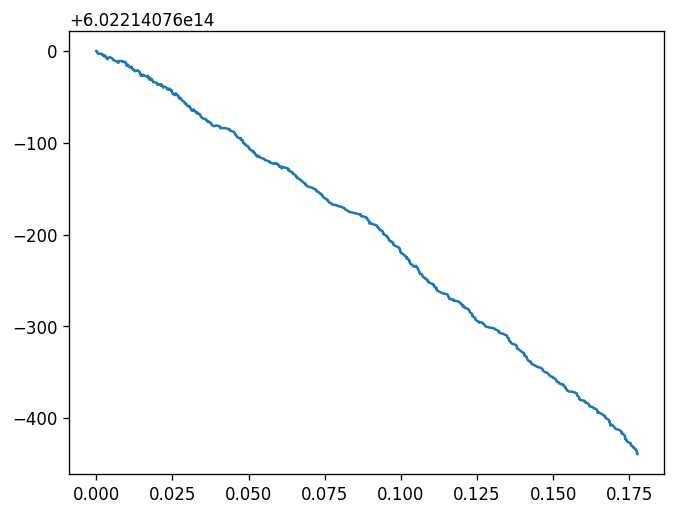

In [53]:
plt.plot(tt, Zn_out)

In [2]:
 flux_columns = {
        "reaction flux": "listeners__FBA_results__reaction_fluxes",
        "external exchange fluxes": "listeners__FBA_results__external_exchange_fluxes",
        "target flux": "listeners__enzyme_kinetics__target_fluxes",
    }

for k, v in flux_columns.items():
    print(k,v)

reaction flux listeners__FBA_results__reaction_fluxes
external exchange fluxes listeners__FBA_results__external_exchange_fluxes
target flux listeners__enzyme_kinetics__target_fluxes


In [3]:
flux_columns.items()

dict_items([('reaction flux', 'listeners__FBA_results__reaction_fluxes'), ('external exchange fluxes', 'listeners__FBA_results__external_exchange_fluxes'), ('target flux', 'listeners__enzyme_kinetics__target_fluxes')])